Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that **the effect of various sources of uncertainty in the model can be factorized**. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

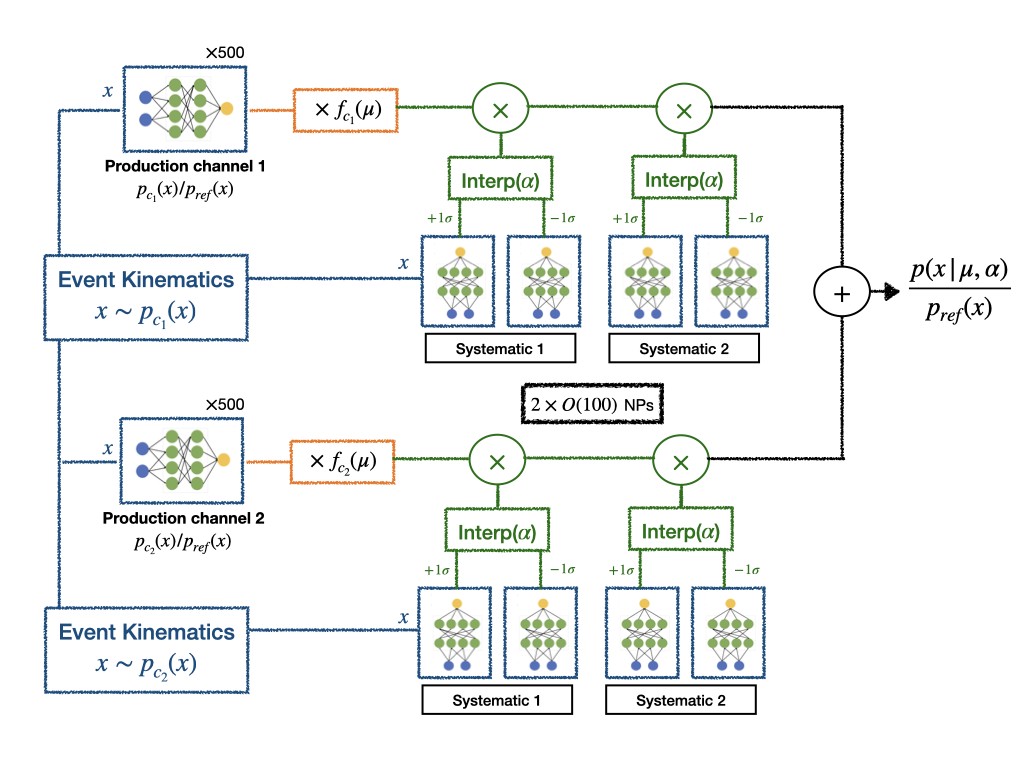

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-08-11 09:36:33.259981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 09:36:33.270738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-11 09:36:33.281976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-11 09:36:33.285826: E external/local_xla/xla/str

In [2]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
PATH_PREFIX = config["PATH_PREFIX"]
PATH_TO_SAVED_DATA = config["PATH_SAVED_DATA"]

In [4]:
# Get the dictionary of labels to processes
labels_dict = config["PROCESS_TO_INT_LABELS_DICT"]

# Signal processes in the model
SIGNAL_PROCESSES = config["SIGNAL_PROCESSES"]

# Background processes in the model
BACKGROUND_PROCESSES = config["BACKGROUND_PROCESSES"]

REF_PROCESSES = config["REFERENCE_PROCESSES"]

MIX_MODEL_HYPOTHESES = config["MIX_MODEL_HYPOTHESES"]

print(SIGNAL_PROCESSES)
print(BACKGROUND_PROCESSES)


['htautau']
['ttbar', 'ztautau']


In [5]:
# Input features for training
features = config["TRAINING_FEATURES"]

# Subset of the features to standardize before training
features_scaling = config["TRAINING_FEATURES_TO_SCALE"]

In [6]:
# Load nominal dataframe
path_to_nominal_dataframe = config["PATH_TO_nominal_DATA"]
dataset_incl_nominal = pd.read_hdf(path_to_nominal_dataframe, key="dataset", mode='r')

In [7]:
# Load systematics dataframes
datasets_syst = {}
systematics_dicts = config["Systematics"]
for systematics_dict in systematics_dicts:
    if systematics_dict["Type"] != "NormPlusShape": continue
    syst_name = systematics_dict["Name"]

    datasets_syst[syst_name] = {}
    
    for direction in ["up", "dn"]:
        path_to_dataframe = systematics_dict[f"weight_{direction}"]
        datasets_syst[syst_name][direction] = pd.read_hdf(path_to_dataframe, key="dataset", mode="r")

In [8]:
all_channels = []

for channel_dict in config["Regions"]:
    all_channels.append(
        channel_dict["Name"]
    )

print(all_channels)

['CR', 'SR_binned', 'SR']


In [9]:
# Apply preselections
preselection_cuts = {}
datasets_nom_channel = {}
datasets_syst_channel = {}
for channel in all_channels:
    preselection_cuts[channel] = next((channel_dict.get('Filter') for channel_dict in config["Regions"] if channel_dict.get('Name') == channel), None)
    datasets_nom_channel[channel] = dataset_incl_nominal.query(preselection_cuts[channel]).copy()
    
    datasets_syst_channel[channel] = {}
    for syst in datasets_syst:
        datasets_syst_channel[channel][syst] = {}
        
        for direction in datasets_syst[syst]:
            datasets_syst_channel[channel][syst][direction] = datasets_syst[syst][direction].query(preselection_cuts[channel]).copy()

In [10]:
list_syst = [syst_dict["Name"] for syst_dict in systematics_dicts]
print(list_syst)

['TES', 'JES']


In [11]:
datasets_syst_channel['SR'].keys()

dict_keys(['TES', 'JES'])

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [13]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

NN_training_syst_process  = {}
path_to_ratios            = {}
path_to_figures           = {}
path_to_models            = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False


for process in labels_dict:
    
    NN_training_syst_process[process]   = {}
    path_to_ratios[process]             = {}
    path_to_figures[process]            = {}
    path_to_models[process]             = {}

    mask_process_nom = (datasets_nom_channel['SR'].type==process)
    dataset_den = datasets_nom_channel['SR'][mask_process_nom].copy()
    
    for dict_syst in config["Systematics"]:

        syst = dict_syst["Name"]
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"):
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        NN_training_syst_process[process][syst] = {}
        path_to_ratios[process][syst]           = {}
        path_to_figures[process][syst]          = {}
        path_to_models[process][syst]           = {}

        for direction in ["up", "dn"]:

            mask_process_syst = (datasets_syst_channel['SR'][syst][direction].type==process)
            
            # Save paths
            top_path                                    = f'{PATH_TO_SAVED_DATA}output_training_systematics/'
            output_name                                 = f'{process}_{syst}_{direction}'
            output_dir                                  = f'{top_path}general_output_{output_name}'
            path_to_ratios[process][syst][direction]    = f'{top_path}output_ratios_{output_name}/'
            path_to_figures[process][syst][direction]   = f'{top_path}output_figures_{output_name}/'
            path_to_models[process][syst][direction]    = f'{top_path}output_model_params_{output_name}/'

            dataset_num = datasets_syst_channel['SR'][syst][direction][mask_process_syst].copy()

            dataset_num['train_labels'] = 1
            dataset_den['train_labels'] = 0

            dataset_num['weights_normed'] = dataset_num['weights'].to_numpy() / dataset_num['weights'].sum()
            dataset_den['weights_normed'] = dataset_den['weights'].to_numpy() / dataset_den['weights'].sum()
            
            # Build a training dataset for the training of p_<process_type>/p_<REF_PROCESSES> density ratio
            dataset_syst_nom = pd.concat([dataset_num, dataset_den])
            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_nom, 
                                                                                   dataset_syst_nom['weights_normed'].to_numpy(),
                                                                                   dataset_syst_nom['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures[process][syst][direction],
                                                                                    path_to_ratios=path_to_ratios[process][syst][direction], 
                                                                                    path_to_models=path_to_models[process][syst][direction],
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)

    del dataset_num, dataset_den
                


In [14]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = True
num_bins_cal = 50

USE_SAVED_MODELS = True
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 0

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process in labels_dict:
    
    for dict_syst in config["Systematics"]:

        syst = dict_syst["Name"]

        print(f"\n\n Training for {syst} systematic for process {process} \n\n")

        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"):
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in ["up", "dn"]:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            




 Training for TES systematic for process htautau 


starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from /home/jsandesara_umass_edu/NSBI-workflow-tutorial/FAIR_universe_Higgs_tautau/cached_data/output_training_systematics/output_model_params_htautau_TES_up/


2025-08-11 09:40:53.070456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1238 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:07:00.0, compute capability: 8.6
2025-08-11 09:40:53.911891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-11 09:40:53.930746: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91100


Calibrating the saved model with 50 bins
0.38813585
0.60942906



The sum of PDFs in ensemble member 0 is 1.0000850942578408


The sum of PDFs using the whole ensemble is 1.0000850942578408



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from /home/jsandesara_umass_edu/NSBI-workflow-tutorial/FAIR_universe_Higgs_tautau/cached_data/output_training_systematics/output_model_params_htautau_TES_dn/
Calibrating the saved model with 50 bins
0.38668185
0.6175549



The sum of PDFs in ensemble member 0 is 1.0000343678598345


The sum of PDFs using the whole ensemble is 1.0000343678598345





 Training for JES systematic for process htautau 


starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from /home/jsandesara_umass_edu/NSBI-workflow-tutorial/FAIR_universe_Higgs_tautau/cached_data/output_training_systematics/output_model_params_htautau_JES_up/
Calibrating the saved model with 50 bins
0.43990046
0.55691

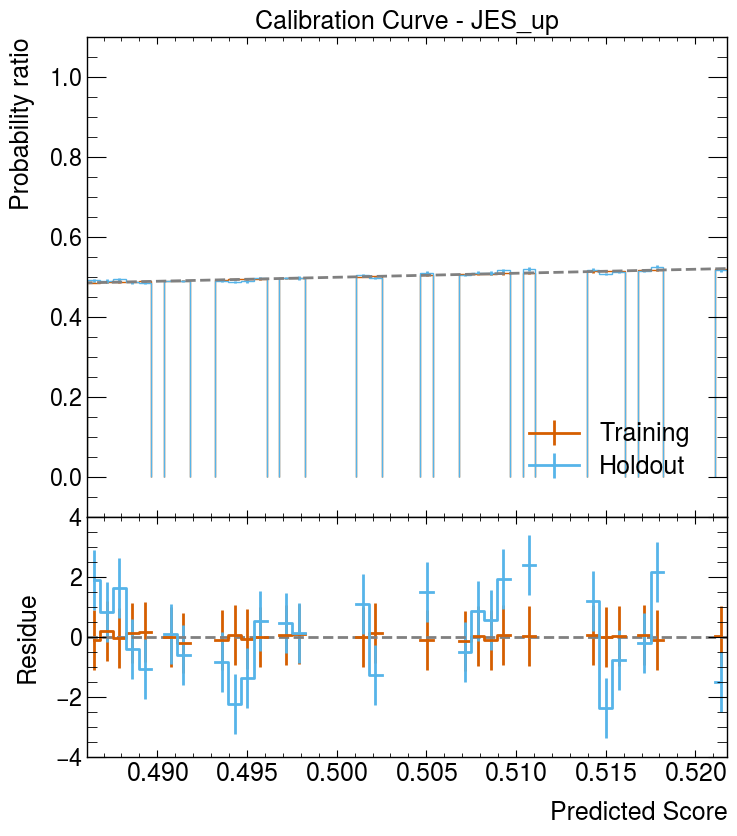

<Figure size 800x600 with 0 Axes>

In [15]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')


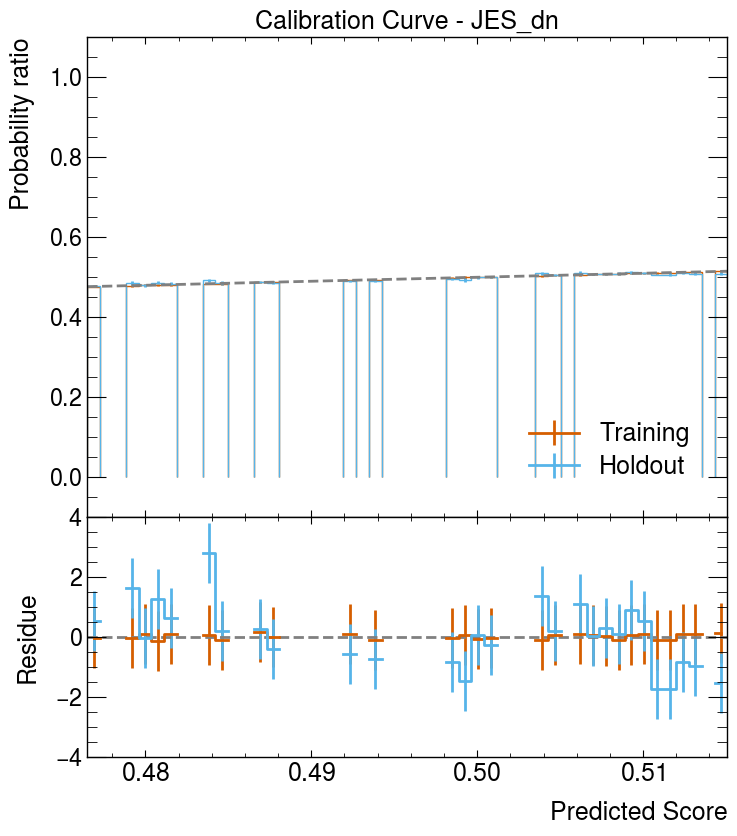

<Figure size 800x600 with 0 Axes>

In [16]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


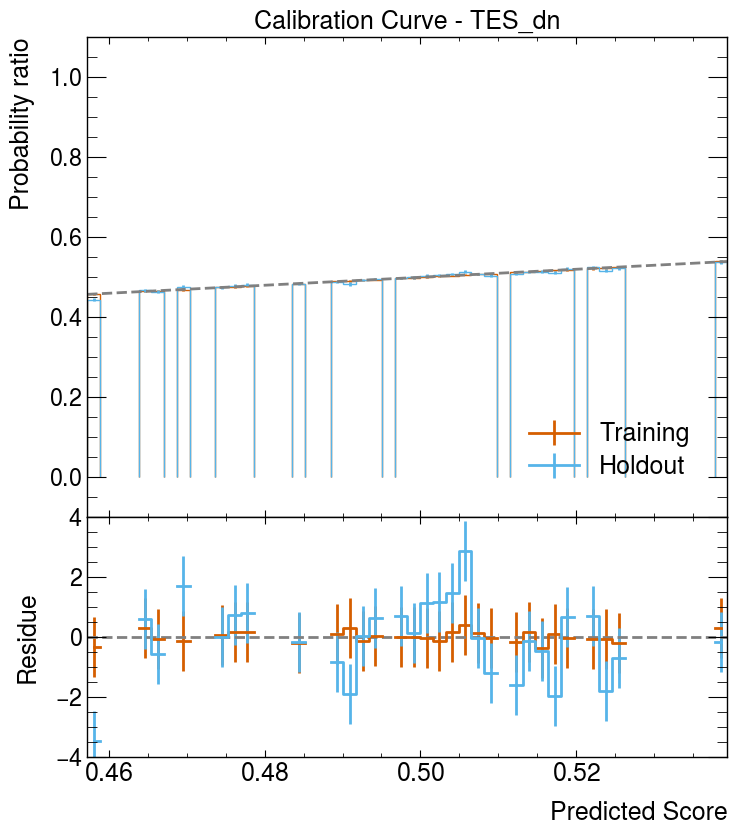

<Figure size 800x600 with 0 Axes>

In [17]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


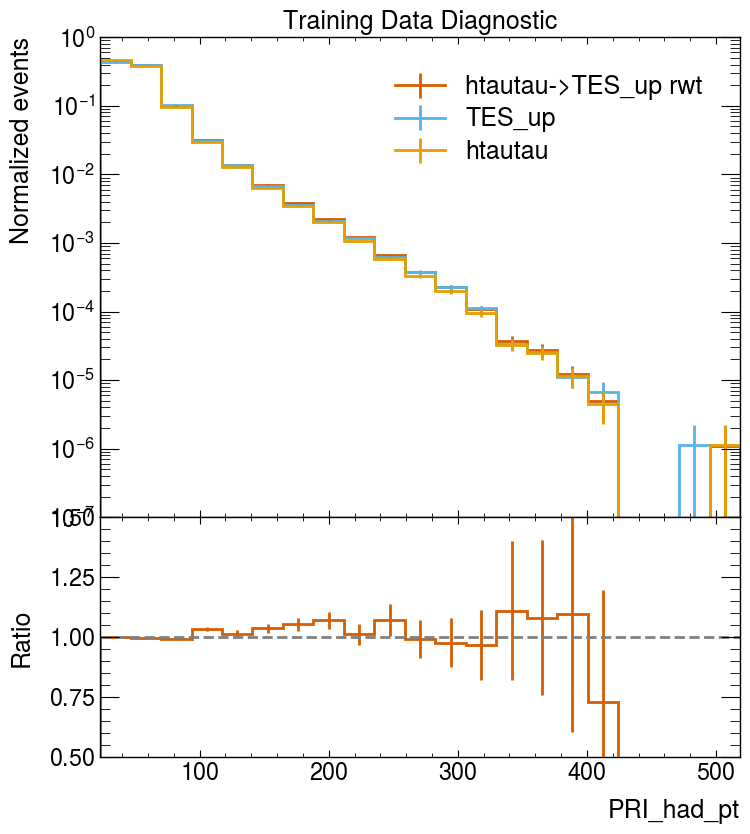

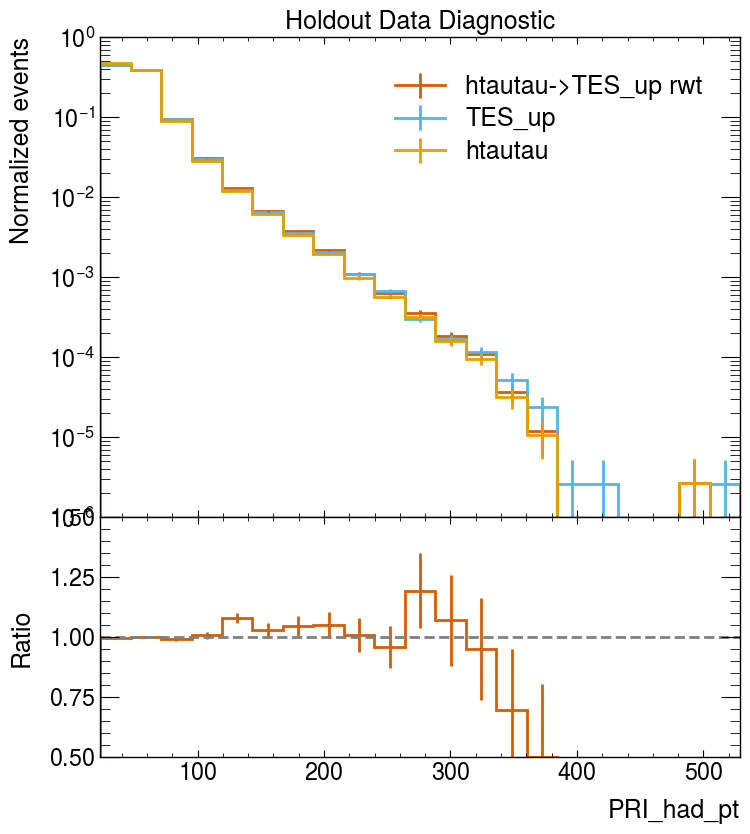

<Figure size 800x600 with 0 Axes>

In [18]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


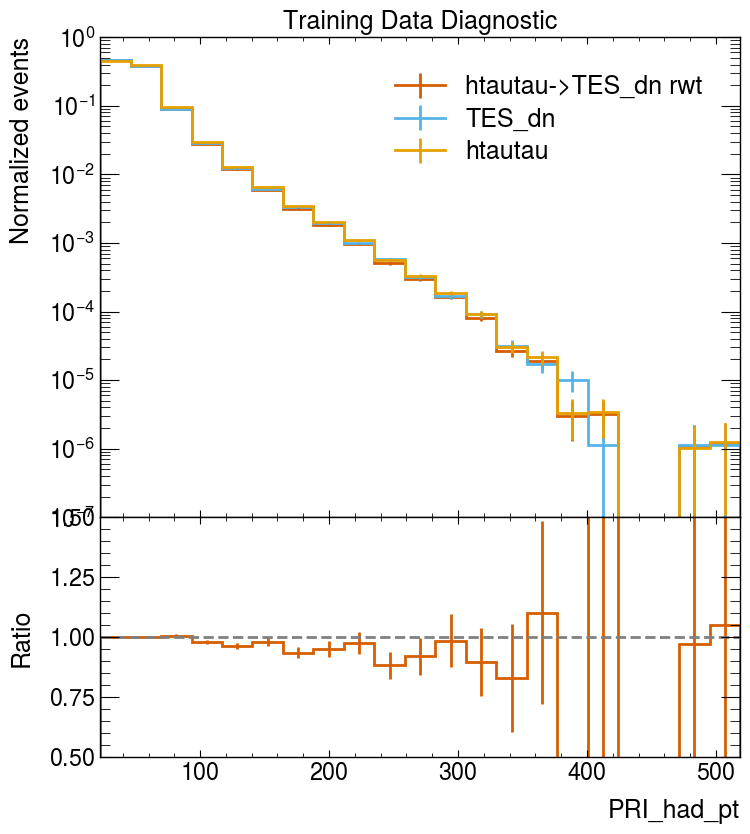

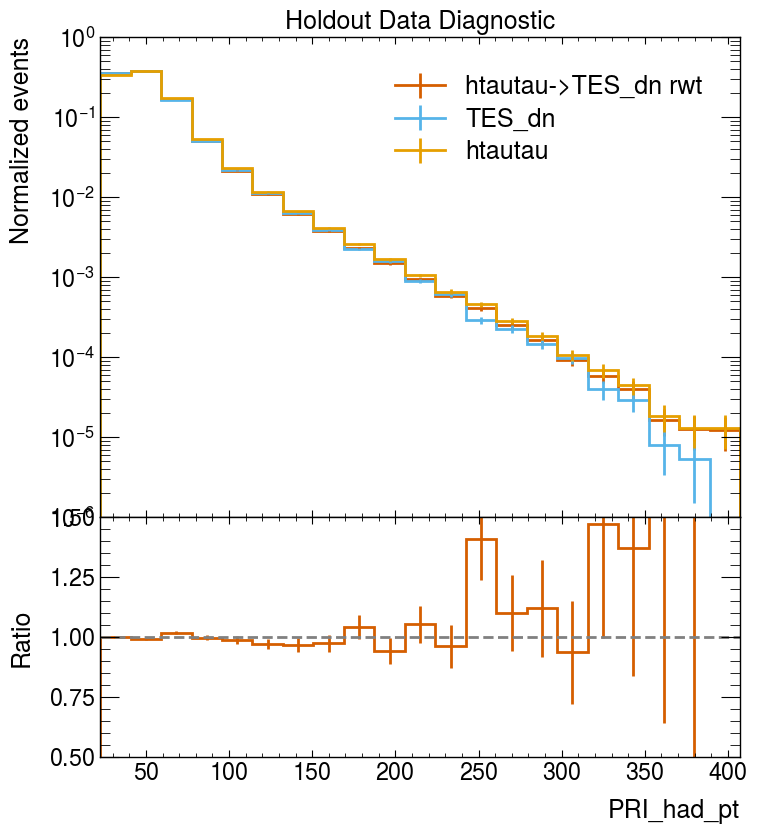

<Figure size 800x600 with 0 Axes>

In [19]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m$ and process $p_c(x)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [20]:
ensemble_aggregation_type = 'mean_ratio'

dataset_eval = datasets_nom_channel["SR"]

path_to_saved_ratios = {}

for process in labels_dict:

    path_to_saved_ratios[process] = {}
    
    for dict_syst in config["Systematics"]:

        syst = dict_syst["Name"]
        
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"): continue

        path_to_saved_ratios[process][syst] = {}
        
        for direction in ["up", "dn"]:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            path_to_saved_ratios[process][syst][direction] = NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval, 
                                                                                        aggregation_type = ensemble_aggregation_type)


Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios


In [25]:
for i, dict_syst in enumerate(config["Systematics"]):

    syst = dict_syst["Name"]

    if (dict_syst["Type"] != "NormPlusShape"): continue

    path_to_saved_ratios[syst] = {}
    
    config["Systematics"][i]["TrainedModels"] = []

    for process in labels_dict:

        if (process not in dict_syst["Samples"]): continue
    
        config["Systematics"][i]["TrainedModels"].append(
            {
                "Name"     : process,
                "ModelsUp"   : path_to_models[process][syst]["up"],
                "RatiosUp"   : path_to_saved_ratios[process][syst]["up"],
                "ModelsDn"   : path_to_models[process][syst]["dn"],
                "RatiosDn"   : path_to_saved_ratios[process][syst]["dn"]
            }
        )

In [27]:
# Save the updated YAML back to the file
with open('config.yml', 'w') as file:
    yaml.dump(
        config, file, 
        default_flow_style=False,
        sort_keys=False, indent=4, width=1000                 
    )

In [ ]:
# # Save the systematic variation on total yields in the SR
# nu_var_SR = {}
# for process in labels_dict:

#     mask_process_nom = datasets_nom_channel['SR'].type==process
#     nu_var_SR[process] = {}
    
#     for dict_syst in config["Systematics"]:

#         syst = dict_syst["Name"]
#         nu_var_SR[process][syst] = {}
        
#         for direction in ["up", "dn"]:
            
#             if process not in dict_syst[syst]['process']:
#                 nu_var_SR[process][syst][direction] = 1.0
#             else:
                
#                 mask_process_syst = (datasets_syst_channel[syst][direction]['SR'].type==process)
                
#                 nu_var_SR[process][syst][direction] = datasets_syst_channel[syst][direction]['SR'][mask_process_syst].weights.sum() / datasets_nom_channel['SR'][mask_process_nom].weights.sum()
#                 if 'down' not in dict_syst[syst]['directions']:
#                     nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['up']
                    
                

In [ ]:
# # Save the Control Region variation histogram
# with open(f"{PATH_SAVED_DATA}yield_SR_variations.pkl", "wb") as fp:
#     pickle.dump(nu_var_SR, fp)